## Technical appendix to Designing behavioral scoring systems with ML components

<div class="alert alert-block alert-info">
<b>Description:</b> This notebook contains a technical appendix on the approach proposed for risk differentiation of probability of default (PD) behavioral credit risk models.</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

import xgboost as xgb
import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.calibration import calibration_curve

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
%%capture
!pip3 install emoji --upgrade
!pip3 install optbinning --upgrade

In [3]:
import emoji

In [4]:
import sys
print(sys.version)
sys.path

3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]


['/Users/sodennygoes/Documents/python/Git/credit-scoring-systems',
 '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip',
 '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10',
 '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload',
 '',
 '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages']

### 💳 Dataset source: [Kaggle - GiveMeSomeCredit](https://www.kaggle.com/competitions/GiveMeSomeCredit/)

In [5]:
# importing data
# Source: https://www.kaggle.com/competitions/GiveMeSomeCredit/rules
train = pd.read_csv('cs-training.csv')

#### Dataset description
| Feature | Description |
| --- | --- |
| SeriousDlqin2yrs | Person experienced 90 days past due delinquency or worse |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits |
| age | Age of borrower in years |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. |
| DebtRatio | Monthly debt payments, alimony,living costs divided by monthy gross income |
| MonthlyIncome | MonthlyIncome |
| NumberOfOpenCreditLinesAndLoans | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) |
| NumberOfTimes90DaysLate | Number of times borrower has been 90 days or more past due |
| NumberRealEstateLoansOrLines | Number of mortgage and real estate loans including home equity lines of credit |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years |
| NumberOfDependents | Number of dependents in family excluding themselves (spouse, children etc.) |

In [6]:
tv = 'SeriousDlqin2yrs' # target variable: into-default 2y
print(f"Average observed default rate : {train[tv].mean():.2%}")

Average observed default rate : 6.68%


In [7]:
# Split data into training and validation sets
trndat, valdat = model_selection.train_test_split\
                                (train, test_size=0.3, random_state=0, stratify=train[[tv]])
print(trndat[tv].value_counts())
print(valdat[tv].value_counts())

## Extract target column as a series
y_trn = trndat.loc[:,tv].astype(int)
y_val = valdat.loc[:,tv].astype(int)

print(f"Average observed default rate (train) : {y_trn.mean():.2%}")
print(f"Average observed default rate (test) : {y_val.mean():.2%}")

0    97982
1     7018
Name: SeriousDlqin2yrs, dtype: int64
0    41992
1     3008
Name: SeriousDlqin2yrs, dtype: int64
Average observed default rate (train) : 6.68%
Average observed default rate (test) : 6.68%


In [8]:
# usage and socio-demography module
feats_module_01 = ['RevolvingUtilizationOfUnsecuredLines',   # utilization rate
                    'age',                                   # age
                    'DebtRatio']                             # debt ratio

# arrears module
feats_module_02 = ['NumberOfTime60-89DaysPastDueNotWorse',   # 60-90 DPD
                   'NumberOfTime30-59DaysPastDueNotWorse',   # 30-60 DPD
                   'NumberOfTimes90DaysLate']                # 90 DPD

### Binning

In [9]:
from optbinning import BinningProcess, OptimalBinning

In [10]:
# economic relationships with defaults for WOE
binning_fit_params_woe = {
    "RevolvingUtilizationOfUnsecuredLines":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "age":
        {
            "monotonic_trend": "descending", 
            "solver": "cp", 
        },
    "DebtRatio":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    
     "NumberOfTime60-89DaysPastDueNotWorse":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    
    "NumberOfTime30-59DaysPastDueNotWorse":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },
    "NumberOfTimes90DaysLate":
        {
            "monotonic_trend": "ascending", 
            "solver": "cp", 
        },

}

In [11]:
# output format of binning process for XGBoost
binning_transform_params_xgb = {
    "RevolvingUtilizationOfUnsecuredLines":
        {
            "metric": "indices"
        },
    "age":
        {
            "metric": "indices"
        },
    "DebtRatio":
        {
            "metric": "indices"
        },
    
     "NumberOfTime60-89DaysPastDueNotWorse":
        {
            "metric": "indices"
        },
    
     "NumberOfTime30-59DaysPastDueNotWorse":
        {
            "metric": "indices"
        },
     "NumberOfTimes90DaysLate":
        {
            "metric": "indices"
        },
}

### Scoring function 1: WOE Logistic Regression

In [12]:
def create_woe_pipeline(X_train, X_test, y_train, y_test):

    binning_process = BinningProcess(
        variable_names=list(X_train.columns),
        binning_fit_params=binning_fit_params_woe,
    )

    logreg = sklearn.linear_model.LogisticRegression(fit_intercept=True, penalty='none')

    pipeline = Pipeline(steps=[("binning_process", binning_process), ("regressor", logreg)])

    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    
    gini = roc_auc_score(y_test, y_pred)*2-1
    
    print(f"Gini : {gini:.2%}")

    return pipeline

In [13]:
woe_lr_01 = create_woe_pipeline(trndat[feats_module_01], valdat[feats_module_01], y_trn, y_val)
print('model parameters:', woe_lr_01[1].intercept_, woe_lr_01[1].coef_) 

woe_lr_02 = create_woe_pipeline(trndat[feats_module_02], valdat[feats_module_02], y_trn, y_val)
print('model parameters:', woe_lr_02[1].intercept_, woe_lr_02[1].coef_) 

# positive WOE coefficients reverse the marginal main effect of the features -> here we observe correct signs

Gini : 57.76%
model parameters: [-2.64346427] [[-0.94692675 -0.50952142 -0.95098197]]
Gini : 56.44%
model parameters: [-2.60434417] [[-0.49756512 -0.66364899 -0.71295059]]


In [14]:
# relative weights (Module 1)
st_weights = abs((np.std(woe_lr_01[0].transform(trndat[feats_module_01]),0).to_numpy() * woe_lr_01[1].coef_))
sum_st_weights = np.sum(abs((np.std(woe_lr_01[0].transform(trndat[feats_module_01]),0).to_numpy() * woe_lr_01[1].coef_)))
weight_vector = st_weights/sum_st_weights
weights = list(zip(trndat[feats_module_01].columns, np.round(weight_vector, 3).ravel()))
df_features = pd.DataFrame(weights, columns=['feature', 'weight'])
print(df_features) # vectors of relative weights from logistic regression, utilization is the strongest feature
print('-----------------------------------------------')
# relative weights (Module 2)
st_weights = abs((np.std(woe_lr_02[0].transform(trndat[feats_module_02]),0).to_numpy() * woe_lr_02[1].coef_))
sum_st_weights = np.sum(abs((np.std(woe_lr_02[0].transform(trndat[feats_module_02]),0).to_numpy() * woe_lr_02[1].coef_)))
weight_vector = st_weights/sum_st_weights
weights = list(zip(trndat[feats_module_02].columns, np.round(weight_vector, 3).ravel()))
df_features = pd.DataFrame(weights, columns=['feature', 'weight'])
print(df_features) # vectors of relative weights from logistic regression, utilization is the strongest feature

                                feature  weight
0  RevolvingUtilizationOfUnsecuredLines   0.694
1                                   age   0.207
2                             DebtRatio   0.099
-----------------------------------------------
                                feature  weight
0  NumberOfTime60-89DaysPastDueNotWorse   0.224
1  NumberOfTime30-59DaysPastDueNotWorse   0.393
2               NumberOfTimes90DaysLate   0.383


### Scoring function 2: XGBoost

In [15]:
def create_xgb_pipeline(X_train, X_test, y_train, y_test, best_params):

    binning_process = BinningProcess(
        variable_names=list(X_train.columns),
        binning_fit_params=binning_fit_params_woe, 
        binning_transform_params=binning_transform_params_xgb)

    xgbmodel = xgb.XGBClassifier(**best_params, use_label_encoder=False)

    pipeline = Pipeline(steps=[("binning_process", binning_process), ("regressor", xgbmodel)])

    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    
    gini = roc_auc_score(y_test, y_pred)*2-1
    
    print(f"Gini : {gini:.2%}")

    return pipeline

In [16]:
val_metrics = ['auc', 'logloss']

bst_params = {
    'base_score': np.mean(y_val)
    , 'gamma': 1
    , 'learning_rate': 0.5
    , 'max_depth': 5
    , 'min_child_weight': 100
    , 'n_estimators': 50
    , 'nthread': 24
    , 'objective': 'binary:logistic'
    , 'reg_alpha': 0
    , 'reg_lambda': 0
#     , 'interaction_constraints': '[[0,2], [1]]'
#     , 'monotone_constraints': '(1, 1, 1)'
    , 'eval_metric': val_metrics
    , 'tree_method': 'hist'
}

In [17]:
xgb_model_01 = create_xgb_pipeline(trndat[feats_module_01], valdat[feats_module_01], y_trn, y_val, bst_params)
xgb_model_02 = create_xgb_pipeline(trndat[feats_module_02], valdat[feats_module_02], y_trn, y_val, bst_params)

Gini : 57.95%
Gini : 56.44%


### 🔮 Discriminatory power and 📏 calibration accuracy

In [18]:
from plot_cap_curve import plot_cap # CAP curve (optbinning version adjusted for multiple curves)
from ECE import get_metrics # Expected Calibration Error / Maximum Calibration Error

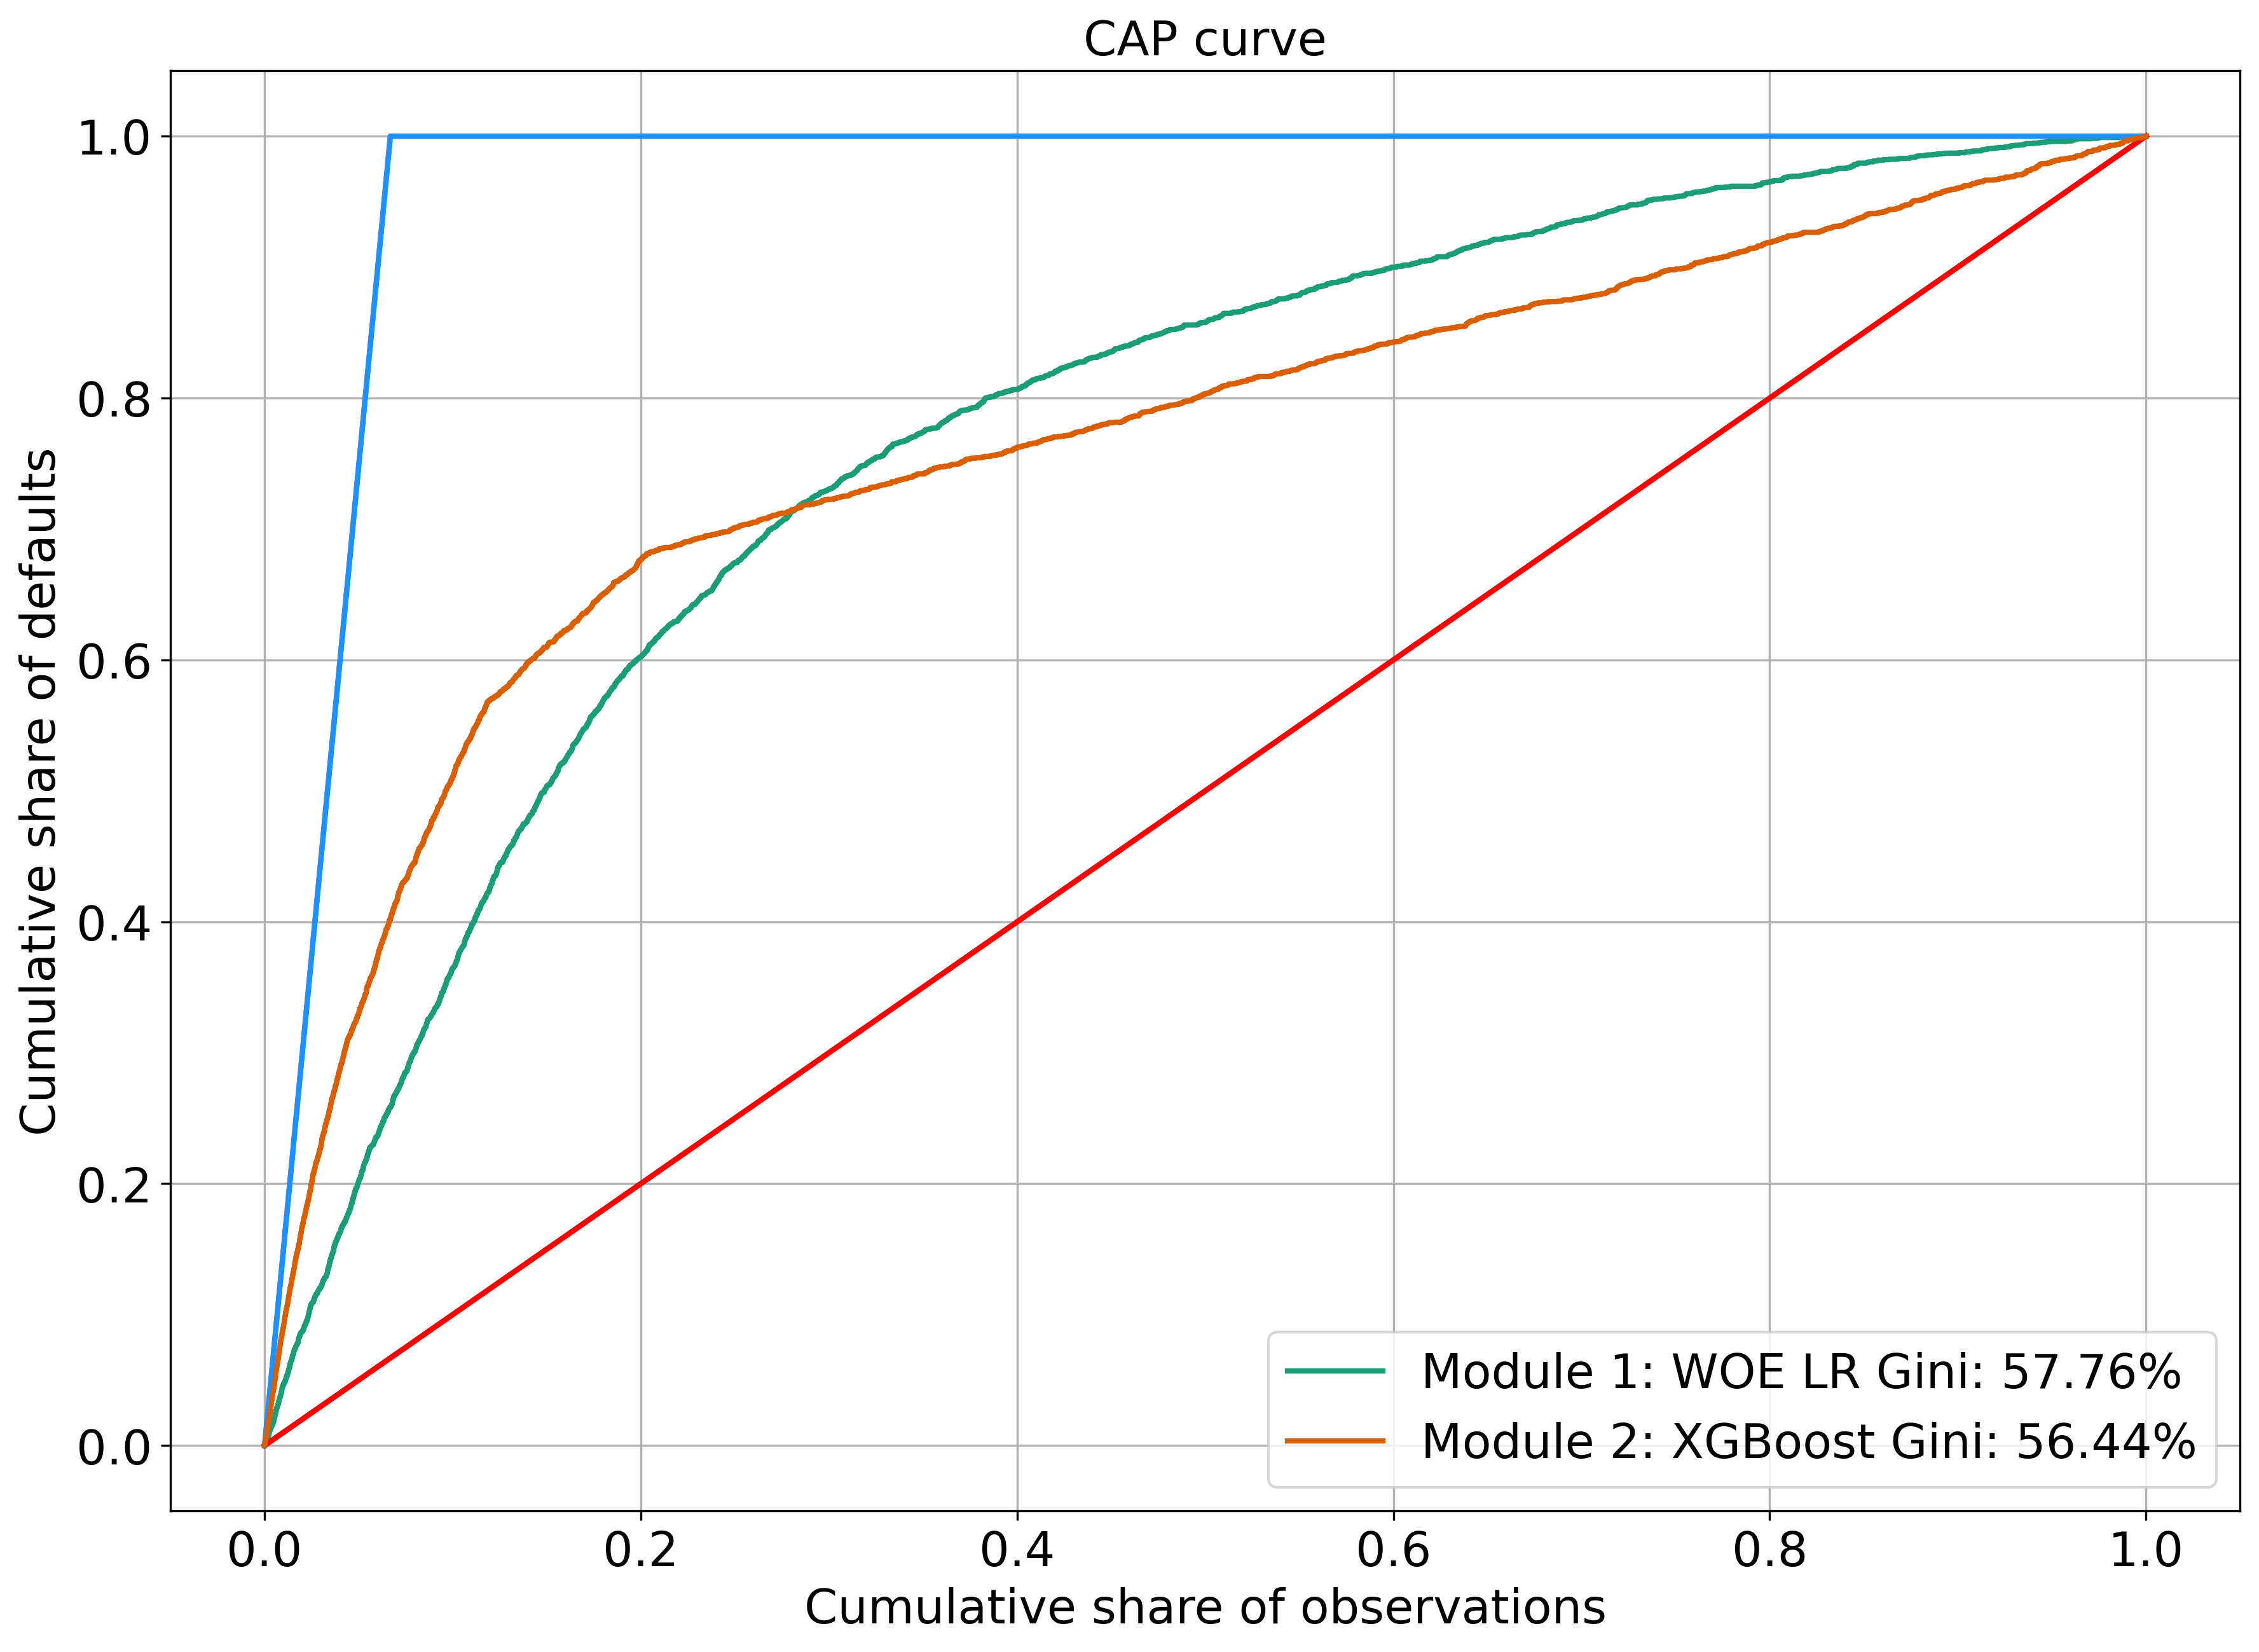

In [19]:
# Discriminatory power
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

plot_cap(y_val, woe_lr_01.predict_proba(valdat[feats_module_01])[:,1], \
         model_name='Module 1: WOE LR', line_color=colors(0))
plot_cap(y_val, xgb_model_02.predict_proba(valdat[feats_module_02])[:,1], \
         model_name='Module 2: XGBoost', line_color=colors(1))

plt.grid()
plt.tick_params(labelsize=18)

plt.xlabel('Cumulative share of observations', fontsize=18)
plt.ylabel('Cumulative share of defaults', fontsize=18)

plt.title('CAP curve', fontsize=18)
plt.legend(fontsize=18) 
# plt.tight_layout()
plt.savefig('graphics/discrimination_diagram.png', bbox_inches='tight')
plt.show()

In [20]:
# making predictions
test_lr = woe_lr_01.predict_proba(valdat[feats_module_01])[:,1]
test_xgb = xgb_model_02.predict_proba(valdat[feats_module_02])[:,1]

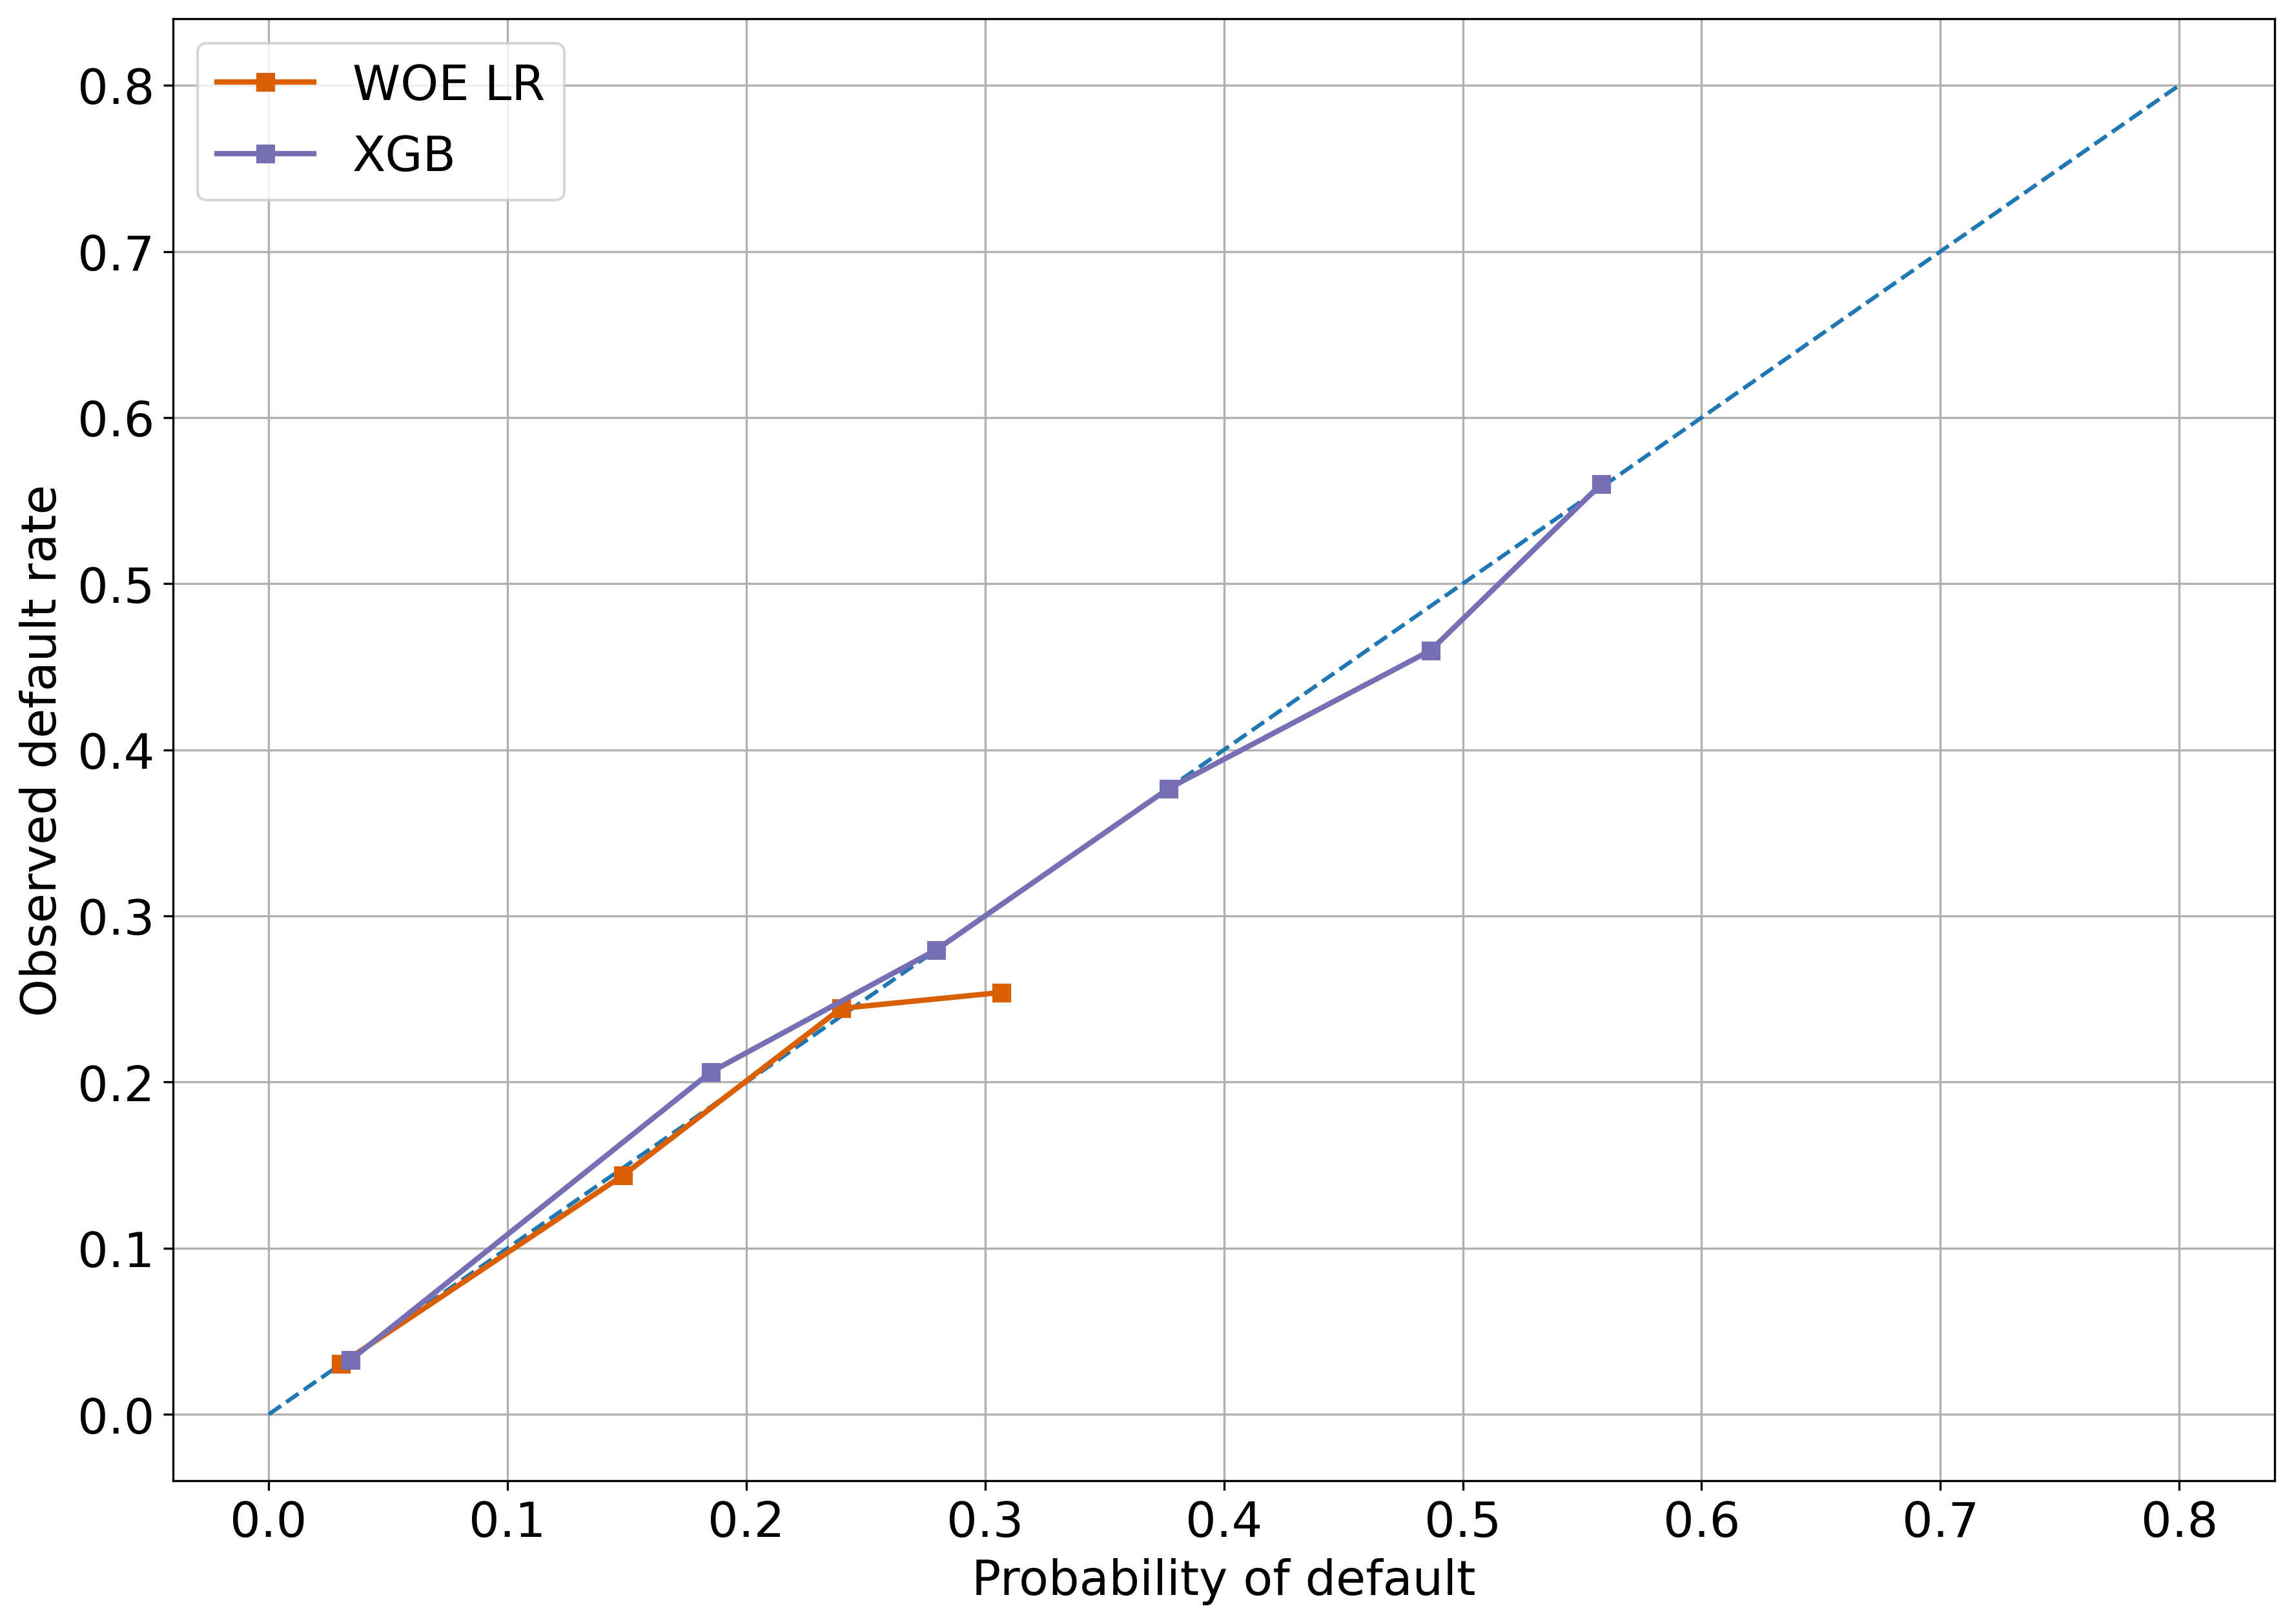

In [21]:
# Calibration accuracy
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

# plot perfect calibration
plt.plot([0, 0.8], [0, 0.8], linestyle='--')

# get calibration curves
fop, mpv = calibration_curve(y_val, test_lr, n_bins=10, strategy='uniform')
fop2, mpv2 = calibration_curve(y_val, test_xgb, n_bins=10, strategy='uniform')

# plot model calibration
plt.plot(mpv, fop, marker="s", linewidth=2, label='WOE LR', color = colors(1))
plt.plot(mpv2, fop2, marker="s", linewidth=2,label='XGB', color = colors(2))
plt.grid()
plt.tick_params(labelsize=18)

plt.xlabel('Probability of default', fontsize=18)
plt.ylabel('Observed default rate', fontsize=18)

plt.legend(fontsize=18)
# plt.tight_layout()
plt.savefig('graphics/calibration_diagram_submodules.png', bbox_inches='tight')
plt.show()

In [22]:
print('---------------------------------------')
print('--------- Calibration metrics ---------')
print('---------------------------------------')
print(f"(1) WOE LR ECE : {get_metrics(y_val, test_lr)[0]:.2%}")
print(f"(2) XGBoost ECE : {get_metrics(y_val, test_xgb)[0]:.2%}")
print('---------------------------------------')
print(f"(1) WOE LR MCE : {get_metrics(y_val, test_lr)[1]:.2%}")
print(f"(2) XGBoost MCE : {get_metrics(y_val, test_xgb)[1]:.2%}")
print('---------------------------------------')

---------------------------------------
--------- Calibration metrics ---------
---------------------------------------
(1) WOE LR ECE : 0.13%
(2) XGBoost ECE : 0.25%
---------------------------------------
(1) WOE LR MCE : 5.29%
(2) XGBoost MCE : 2.67%
---------------------------------------


### 🔗 Integration of submodules into a metascore

In this step we use an XGBoost to integrate two submodular scores using a monotonic XGBoost. For more information regarding monotonic constraints feature in XGBoost please see:  <a href="https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html">Monotonic Constraints</a>

In [23]:
from xgboost import XGBClassifier

In [24]:
# getting probabilities from the two submodules - train
logreg_probs = np.log(woe_lr_01.predict_proba(trndat[feats_module_01])[:,1]/ \
                      (1-woe_lr_01.predict_proba(trndat[feats_module_01])[:,1]))

xgbst_probs = np.log(xgb_model_02.predict_proba(trndat[feats_module_02])[:,1]/ \
                     (1-xgb_model_02.predict_proba(trndat[feats_module_02])[:,1]))

# getting probabilities from the two submodules - test
test_logreg_probs = np.log(woe_lr_01.predict_proba(valdat[feats_module_01])[:,1]/ \
                           (1-woe_lr_01.predict_proba(valdat[feats_module_01])[:,1]))

test_xgbst_probs = np.log(xgb_model_02.predict_proba(valdat[feats_module_02])[:,1]/ \
                          (1-xgb_model_02.predict_proba(valdat[feats_module_02])[:,1]))

In [25]:
train_scores = np.column_stack((xgbst_probs, logreg_probs))
test_scores = np.column_stack((test_xgbst_probs, test_logreg_probs))

print(f"{len(train_scores), len(test_scores)}")

(105000, 45000)


In [26]:
print(val_metrics)

bst_params_int = {
    'gamma': 1             
    , 'learning_rate': 0.06 
    , 'max_depth': 9
    , 'min_child_weight': 100
    , 'n_estimators': 800
    , 'nthread': 24
    , 'objective': 'binary:logitraw'
    , 'random_state': 42
    , 'colsample_bytree': 0.8
    , 'colsample_bylevel': 0.8
    , 'min_child_weight': 0.8
    , 'monotone_constraints': '(1,1)' # enforcing monotonicity
    , 'eval_metric': val_metrics
    , 'tree_method': 'hist'
}

final_model = XGBClassifier(**bst_params_int)
final_model.fit(train_scores, y_trn)
final_logit = final_model.predict_proba(test_scores)[:, 1]
final_proba = 1/(1+np.exp(-final_logit))

['auc', 'logloss']


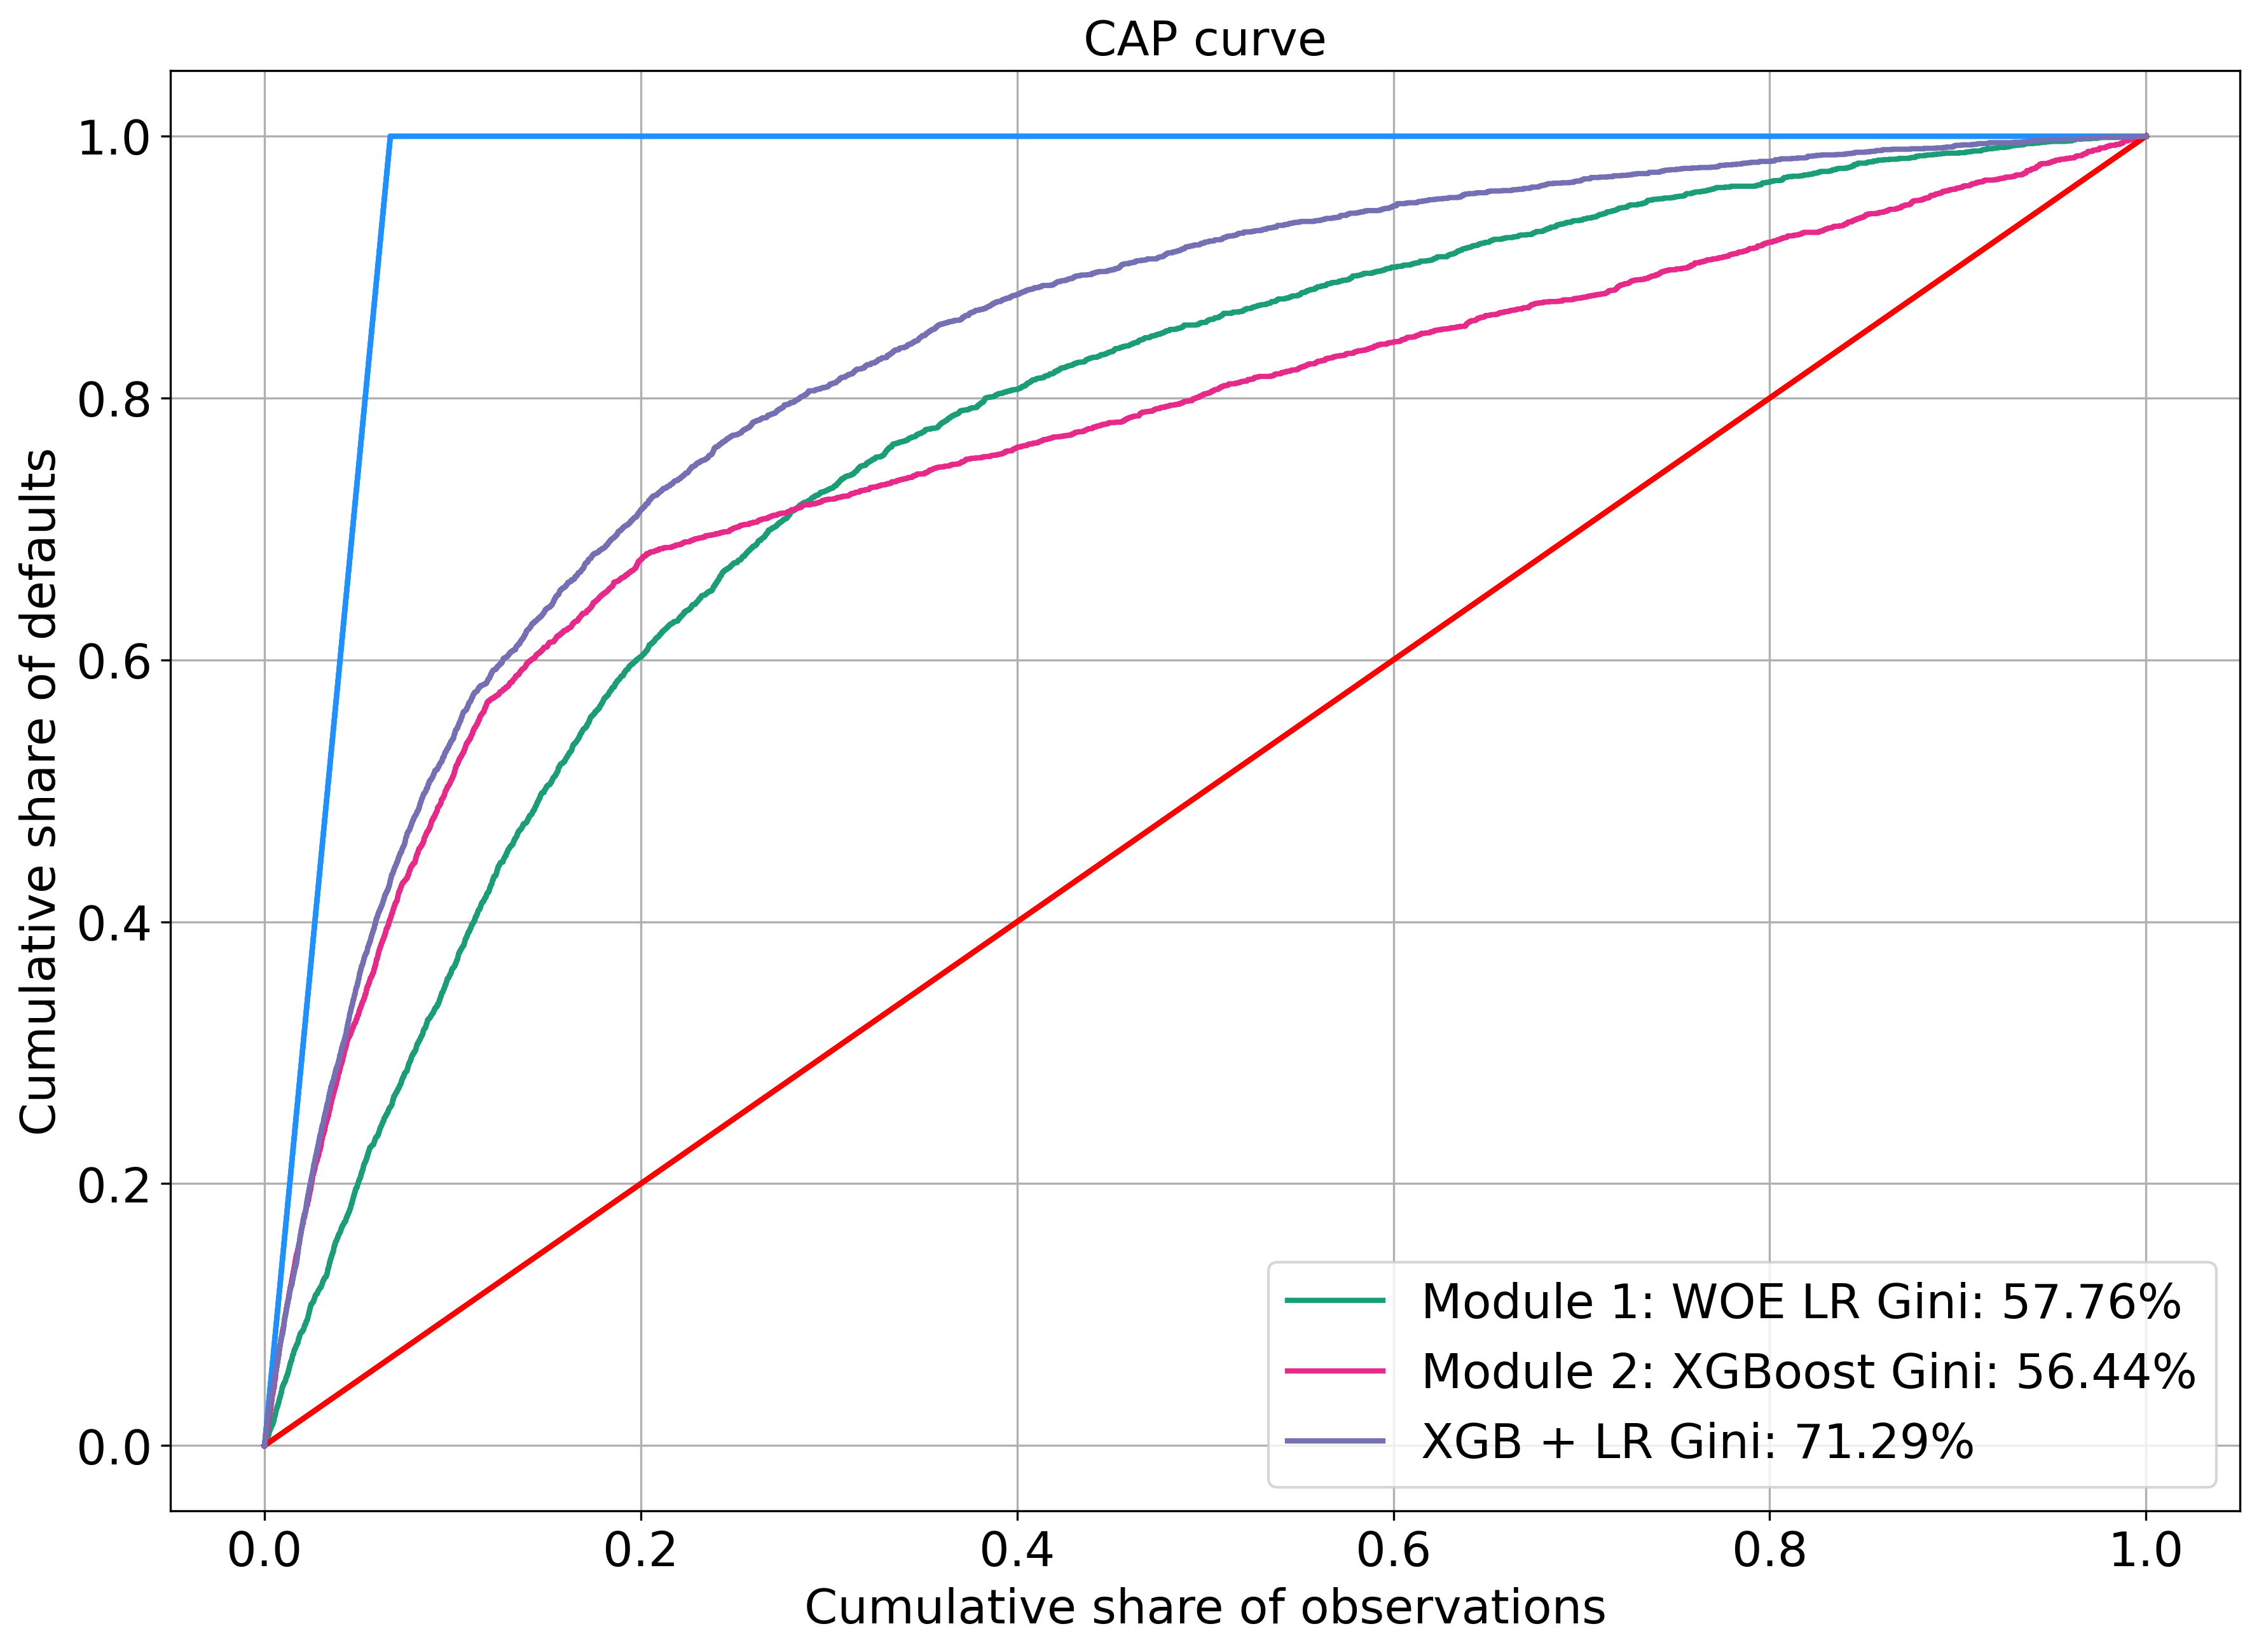

In [27]:
# Discriminatory power
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

# fig, ax = plt.subplots(figsize=(12, 6))
plot_cap(y_val, woe_lr_01.predict_proba(valdat[feats_module_01])[:,1], model_name='Module 1: WOE LR', line_color=colors(0))
plot_cap(y_val, xgb_model_02.predict_proba(valdat[feats_module_02])[:,1], model_name='Module 2: XGBoost', line_color=colors(3))
plot_cap(y_val, final_model.predict_proba(test_scores)[:,1], model_name='XGB + LR', line_color=colors(2))
# plt.axvline(x=0.3, linestyle='--', color='r')

plt.grid()
plt.tick_params(labelsize=18)

plt.xlabel('Cumulative share of observations', fontsize=18)
plt.ylabel('Cumulative share of defaults', fontsize=18)

plt.legend(fontsize=18) 
plt.title('CAP curve', fontsize=18)
# plt.tight_layout()
plt.savefig('graphics/discrimination_diagram_final.png', bbox_inches='tight')
plt.show()

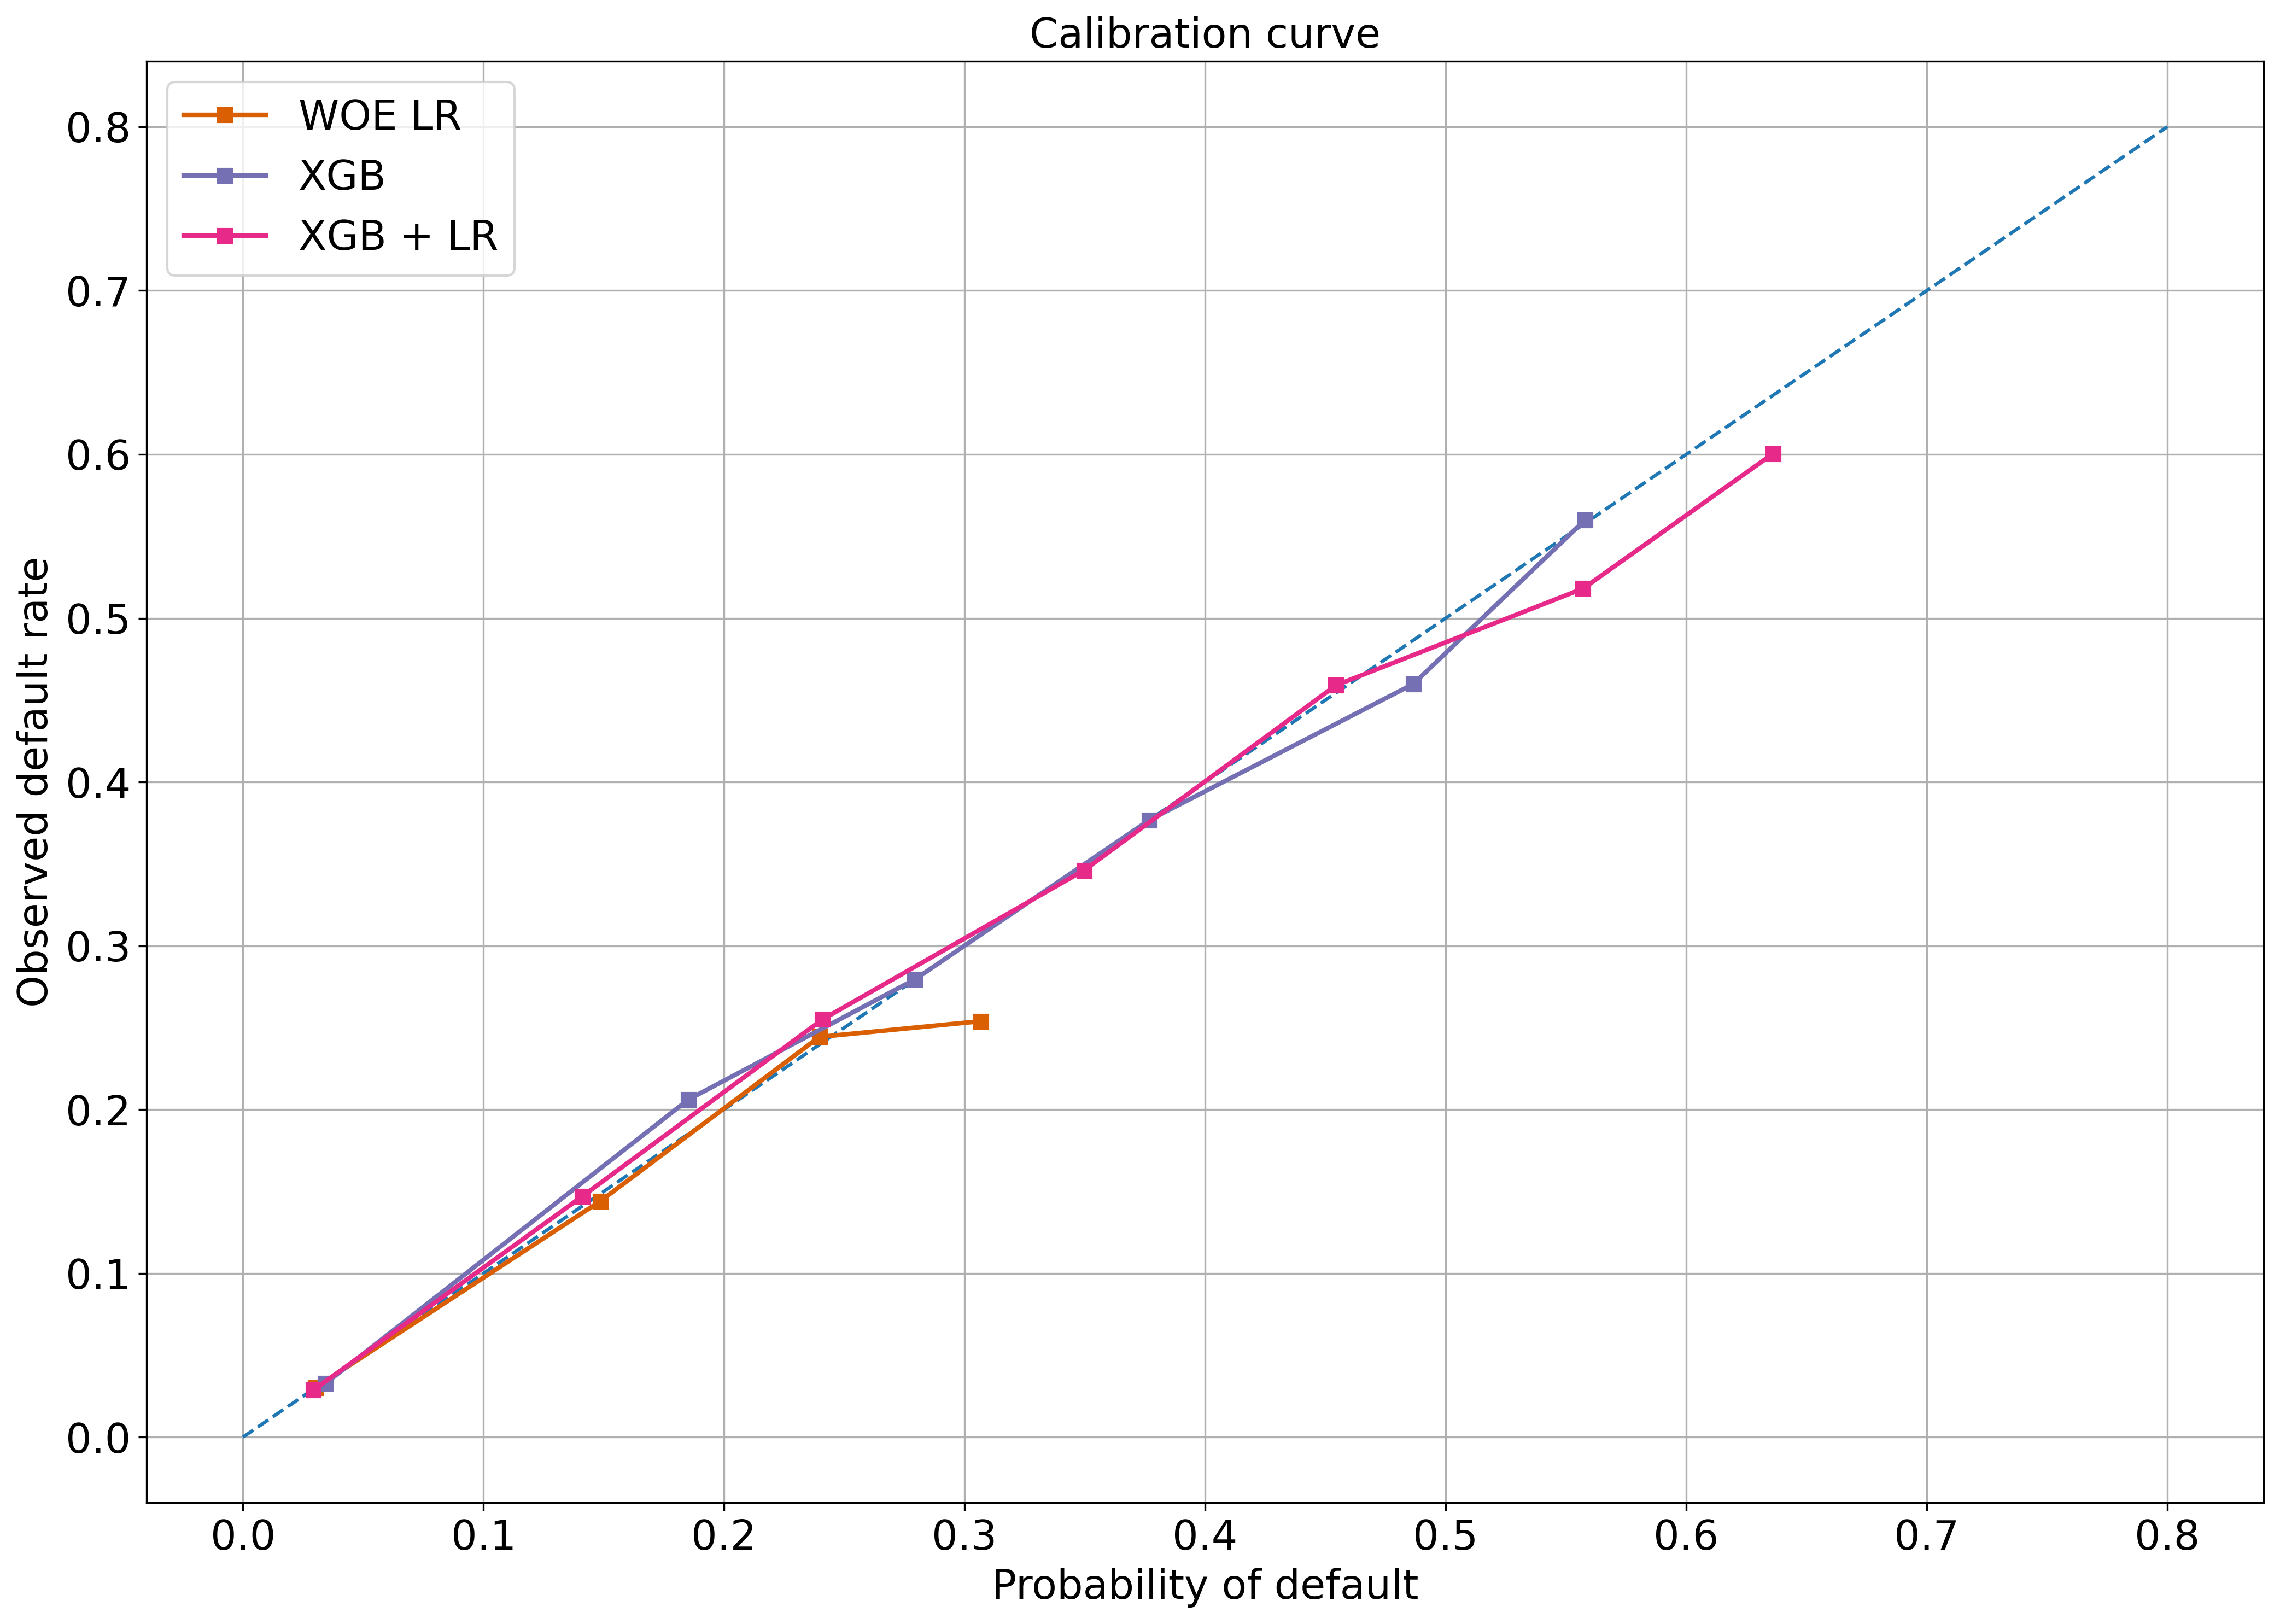

In [28]:
# Calibration accuracy
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

# plot perfect calibration
plt.plot([0, 0.8], [0, 0.8], linestyle='--')

# get calibration curves
fop, mpv = calibration_curve(y_val, test_lr, n_bins=10, strategy='uniform')
fop2, mpv2 = calibration_curve(y_val, test_xgb, n_bins=10, strategy='uniform')
fop3, mpv3 = calibration_curve(y_val, final_proba, n_bins=10, strategy='uniform')

# plot model calibration
plt.plot(mpv, fop, marker="s", linewidth=2, label='WOE LR', color = colors(1))
plt.plot(mpv2, fop2, marker="s", linewidth=2,label='XGB', color = colors(2))
plt.plot(mpv3, fop3, marker="s", linewidth=2,label='XGB + LR', color = colors(3))
plt.grid()
plt.tick_params(labelsize=18)

plt.xlabel('Probability of default', fontsize=18)
plt.ylabel('Observed default rate', fontsize=18)

plt.legend(fontsize=18)
plt.title('Calibration curve', fontsize=18)
plt.tight_layout()
plt.savefig('graphics/calibration_diagram_final.png', bbox_inches='tight')
plt.show()

In [29]:
print('---------------------------------------')
print('--------- Calibration metrics ---------')
print('---------------------------------------')
print(f"(Module 1) WOE LR ECE : {get_metrics(y_val, test_lr)[0]:.2%}")
print(f"(Module 2) XGBoost ECE : {get_metrics(y_val, test_xgb)[0]:.2%}")
print(f"(Metascore) XGBoost + WOE LR ECE : {get_metrics(y_val, final_proba)[0]:.2%}")
print('---------------------------------------')
print(f"(Module 1) WOE LR MCE : {get_metrics(y_val, test_lr)[1]:.2%}")
print(f"(Module 2) XGBoost MCE : {get_metrics(y_val, test_xgb)[1]:.2%}")
print(f"(Metascore) XGBoost + WOE LR MCE : {get_metrics(y_val, final_proba)[1]:.2%}")
print('---------------------------------------')

---------------------------------------
--------- Calibration metrics ---------
---------------------------------------
(Module 1) WOE LR ECE : 0.13%
(Module 2) XGBoost ECE : 0.25%
(Metascore) XGBoost + WOE LR ECE : 0.21%
---------------------------------------
(Module 1) WOE LR MCE : 5.29%
(Module 2) XGBoost MCE : 2.67%
(Metascore) XGBoost + WOE LR MCE : 3.91%
---------------------------------------


## 🎯 Accuracy back-test

In this step we use a simple algorithm to calculate a proportion of defaults that would be avoided if we used a specific cut-off PD midpoint from a given rating scale.

In [30]:
from acc_back_testing import accuracy_back_test

In [31]:
# creating a pandas dataframe with predictions and default columns
dr_scores = np.column_stack((final_proba, y_val))
dr_df = pd.DataFrame(dr_scores, columns=['metascore', 'default'])

In [32]:
bin_edges = [0.001, 0.02, 0.025, 0.03, 0.035, 0.04, 0.049, 0.071, 0.1055, 0.2000, 0.4754] # rating scale midpoints
accuracy_set = accuracy_back_test(bin_edges, dr_df.default, dr_df.metascore)

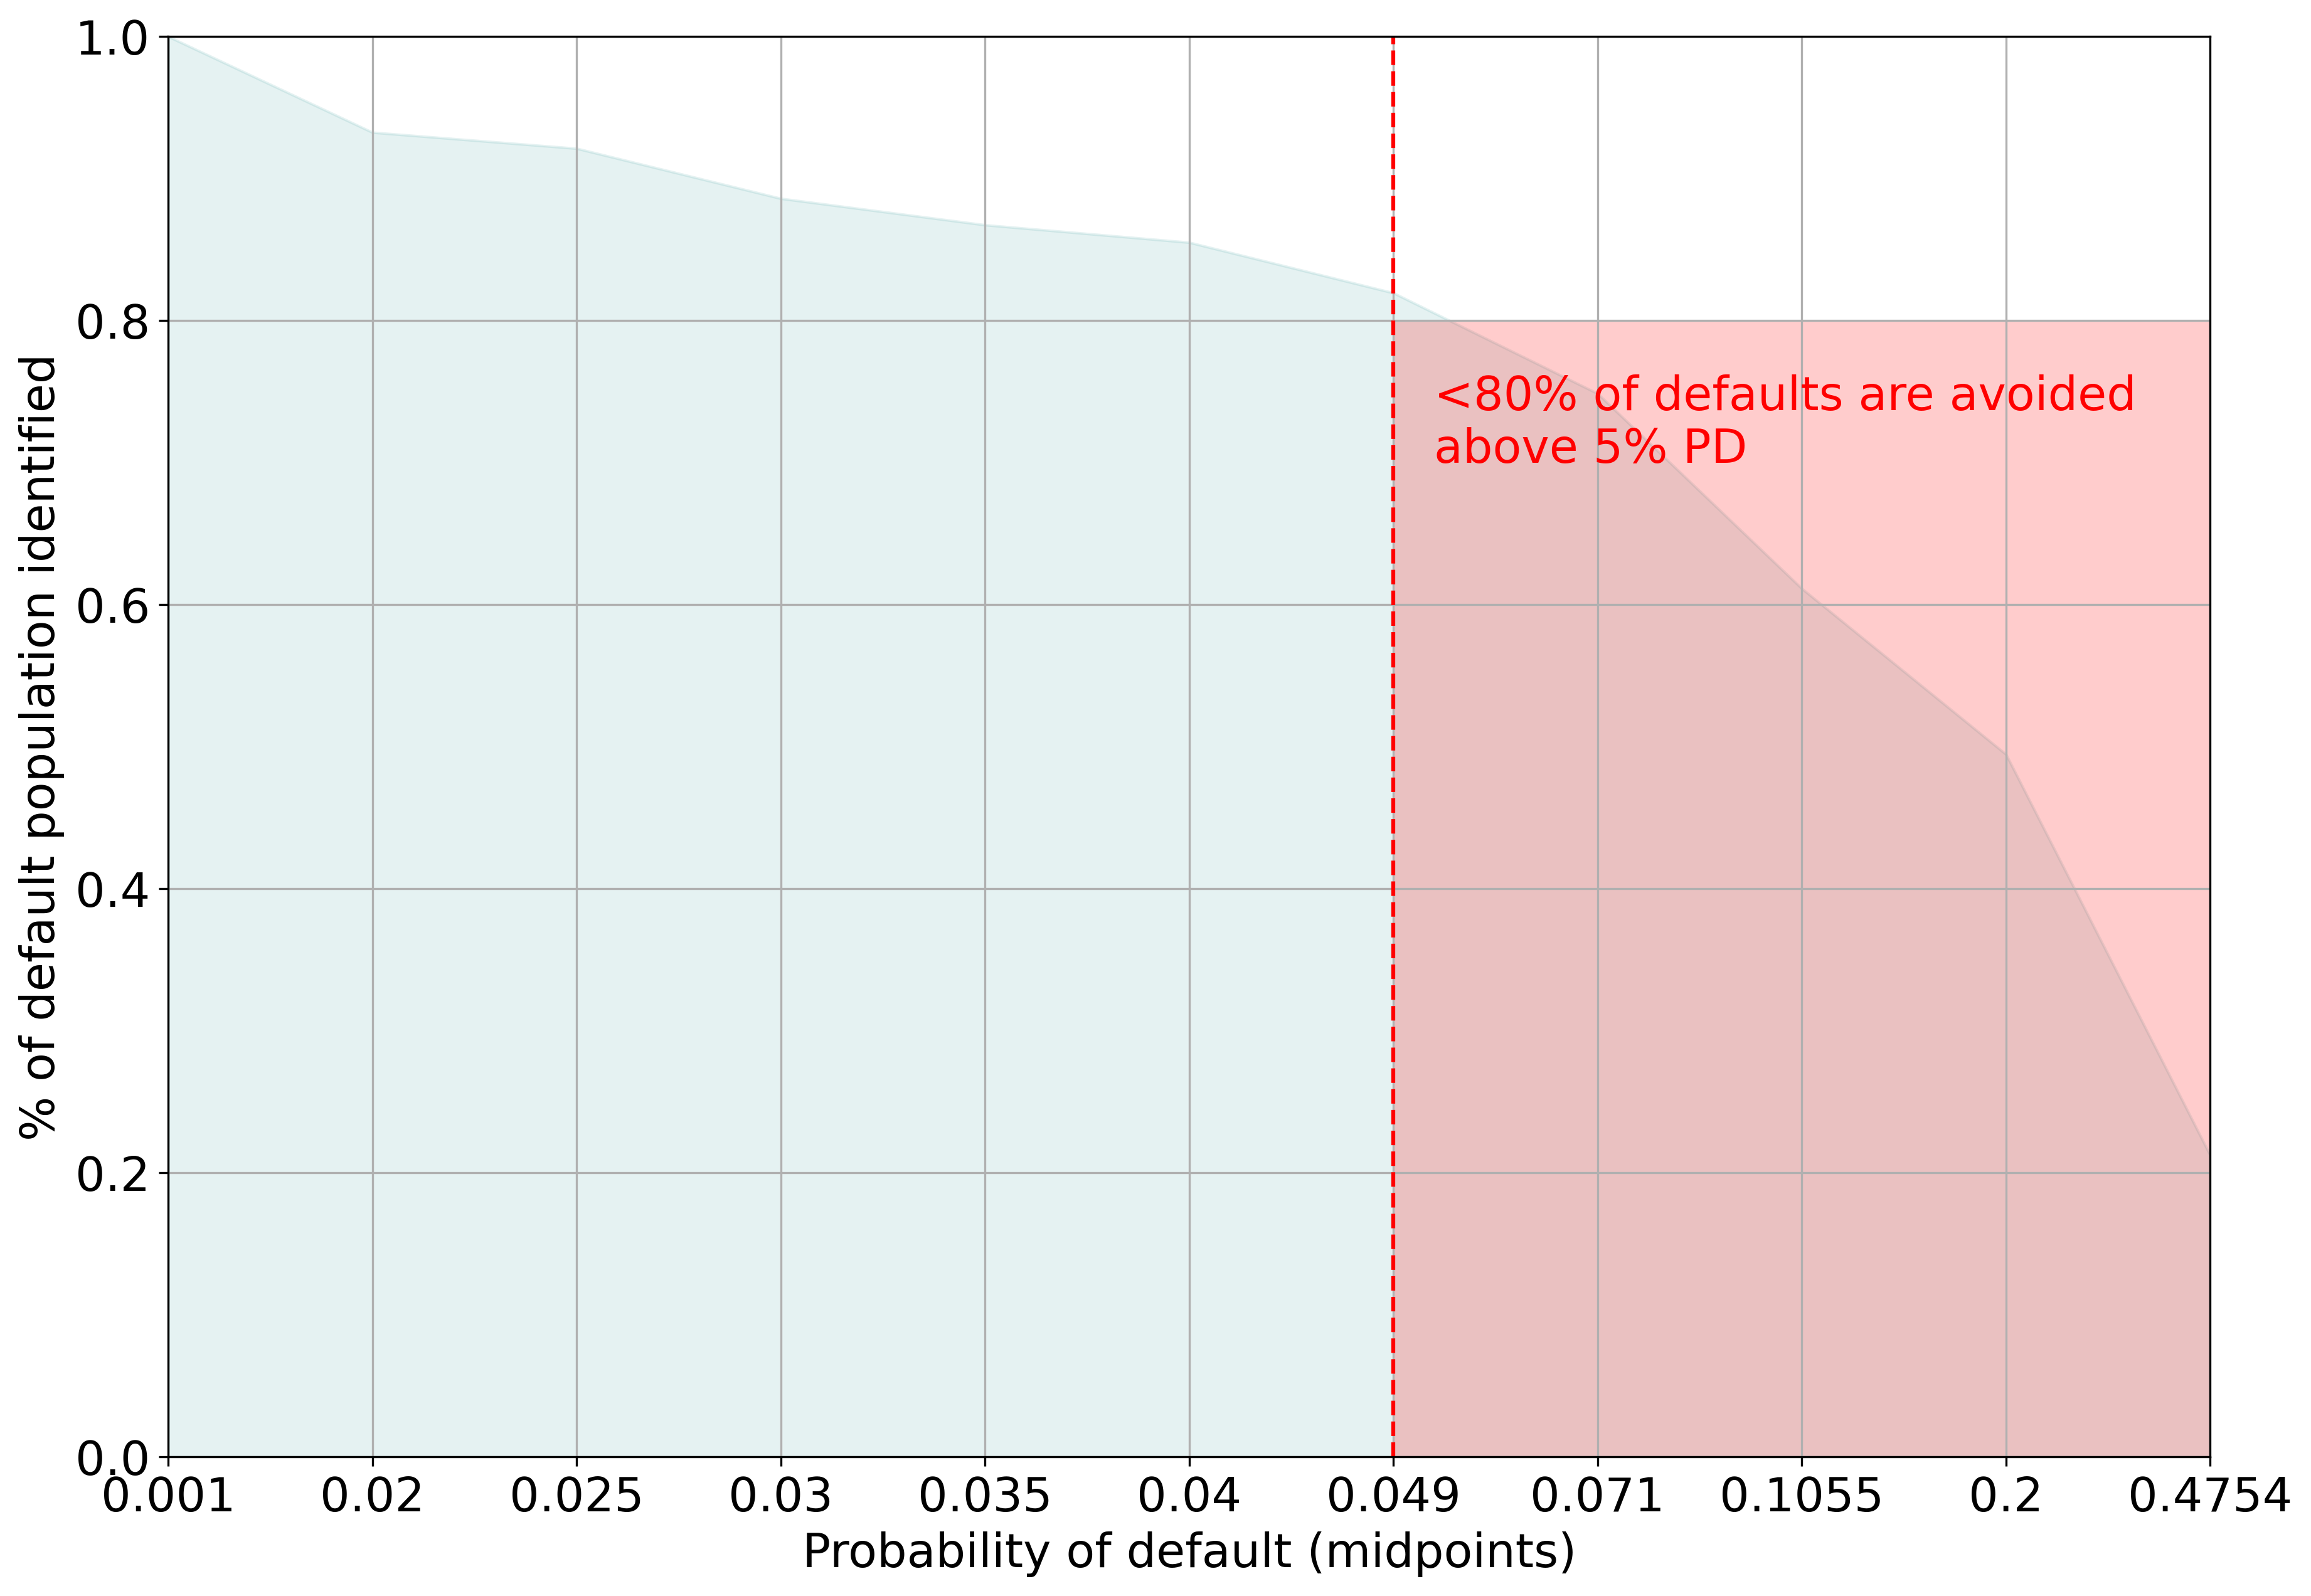

In [33]:
# Back-test visualization
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

plt.fill_between(range(0,11), accuracy_set.accuracy, color='teal', alpha=0.1)
plt.axvline(x=6, linestyle='--', color='red')

rect=mpatches.Rectangle((6, 0), 6, 0.8, 
                       alpha=0.2,
                       facecolor="red")

plt.text(6.2, 0.7, '<80% of defaults are avoided\nabove 5% PD', 
         fontsize = 18, color='red')

# plt.text(0.2, 0.7, '80% of defaults are avoided\nbelow 5% PD', 
#          fontsize = 18, color='teal')

plt.grid()
plt.gca().add_patch(rect)
xi = list(range(len(bin_edges)))
plt.xticks(xi, bin_edges)
plt.tick_params(labelsize=18)

plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Probability of default (midpoints)', fontsize=18)
plt.ylabel('% of default population identified', fontsize=18)

plt.savefig('graphics/acc_back_test.png', bbox_inches='tight')

plt.show()